In [1]:
# 导入所需库
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image



In [2]:
# 定义图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize为224x224
    transforms.ToTensor(),          # 转为Tensor
])

# 数据根目录
data_dir = '../../Data/food-11'

# 训练集：只用有标签
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'training', 'labeled'),
    transform=transform
)

# 验证集
val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'validation'),
    transform=transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 类别名
class_names = train_dataset.classes

# GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("使用设备：", device)


使用设备： cuda


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classed=11):
        super(SimpleCNN, self).__init__()

        # 卷积部分
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), # 输出16x224x224
            nn.ReLU(),
            nn.MaxPool2d(2), # 输出16x112x112
            nn.Conv2d(16, 32, 3, padding=1), # 输出32x112x112
            nn.ReLU(),
            nn.MaxPool2d(2), # 输出32x56x56
        )

        # 全连接部分
        # 先降维+非线性增强；再映射到分类空间
        self.fc = nn.Sequential(
            nn.Flatten(), # 输出100352
            nn.Linear(32 * 56 * 56, 256), # 输出256
            nn.ReLU(),
            nn.Linear(256, num_classed) # 输出11
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [4]:
# 模型训练
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, model_name='Model'):
    # TensorBoard日志
    writer = SummaryWriter(log_dir=f'runs/{model_name}')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm进度条
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反向
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 统计
            running_loss += loss.item() * inputs.size(0) # 累计损失：平均损失量x当前批次样本数量
            _, preds = torch.max(outputs, 1) # 获取模型预测的类别类型
            correct += (preds == labels).sum().item() # 正确预测数累计： .item()将结果转换为python标量
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

        # 平均指标
        epoch_loss = running_loss / total
        epoch_acc = correct / total

        # TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)

        # 验证
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels) # 
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc  = val_correct / len(val_loader.dataset)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        print(f'Epoch {epoch+1}: Train Acc={epoch_acc:.4f}, Val Acc = {val_acc:.4f}')

    writer.close()

In [5]:
# 错误预测可视化
def show_misclassified(model, dataloader, num_images=5):
    model.eval()
    misclassifed = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)

            # 记录错误
            for img, label, pred in zip(inputs, labels, preds): # 遍历当前批次中的每个样本、真实标签和预测标签
                if label != pred:
                    misclassifed.append((img.cpu(), label.cpu(), pred.cpu())) # 将数据移回 CPU（避免 GPU 内存占用）
                if len(misclassifed) >= num_images:
                    break
            
            if len(misclassifed) >= num_images:
                break
    
    # 绘图
    plt.figure(figsize=(15, 5))
    for i, (img, true, pred) in enumerate(misclassifed): # 遍历 misclassifed 列表
        img = img.permute(1, 2, 0).numpy() # 调整图像格式​（Matplotlib需要格式）
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"True:{class_names[true]}\nPred:{class_names[pred]}")
        plt.axis('off')

    plt.show()

Epoch 1: Train Acc=0.1240, Val Acc = 0.2030


Epoch 2: Train Acc=0.2201, Val Acc = 0.2333


Epoch 3: Train Acc=0.2935, Val Acc = 0.2591


Epoch 4: Train Acc=0.3188, Val Acc = 0.2652


Epoch 5: Train Acc=0.3630, Val Acc = 0.2742


Epoch 6: Train Acc=0.3909, Val Acc = 0.2924


Epoch 7: Train Acc=0.4266, Val Acc = 0.2803


Epoch 8: Train Acc=0.4412, Val Acc = 0.3152


Epoch 9: Train Acc=0.4948, Val Acc = 0.3076


Epoch 10: Train Acc=0.5062, Val Acc = 0.3258


Epoch 11: Train Acc=0.5536, Val Acc = 0.3227


Epoch 12: Train Acc=0.5727, Val Acc = 0.3000


Epoch 13: Train Acc=0.6023, Val Acc = 0.2803


Epoch 14: Train Acc=0.6302, Val Acc = 0.3288


Epoch 15: Train Acc=0.6513, Val Acc = 0.3121


Epoch 16: Train Acc=0.6831, Val Acc = 0.3273


Epoch 17: Train Acc=0.7023, Val Acc = 0.3364


Epoch 18: Train Acc=0.7412, Val Acc = 0.3167


Epoch 19: Train Acc=0.7481, Val Acc = 0.3045


Epoch 20: Train Acc=0.7808, Val Acc = 0.3318


Epoch 21: Train Acc=0.7903, Val Acc = 0.3136


Epoch 22: Train Acc=0.8211, Val Acc = 0.3227


Epoch 23: Train Acc=0.8386, Val Acc = 0.2970


Epoch 24: Train Acc=0.8516, Val Acc = 0.3015


Epoch 25: Train Acc=0.8604, Val Acc = 0.3061


Epoch 26: Train Acc=0.8812, Val Acc = 0.2955


Epoch 27: Train Acc=0.9016, Val Acc = 0.3273


Epoch 28: Train Acc=0.9188, Val Acc = 0.2939


Epoch 29: Train Acc=0.9302, Val Acc = 0.3015


Epoch 30: Train Acc=0.9179, Val Acc = 0.3182


Epoch 31: Train Acc=0.9445, Val Acc = 0.2985


Epoch 32: Train Acc=0.9516, Val Acc = 0.3000


Epoch 33: Train Acc=0.9669, Val Acc = 0.2939


Epoch 34: Train Acc=0.9692, Val Acc = 0.2909


Epoch 35: Train Acc=0.9727, Val Acc = 0.2727


Epoch 36: Train Acc=0.9734, Val Acc = 0.2924


Epoch 37: Train Acc=0.9776, Val Acc = 0.3076


Epoch 38: Train Acc=0.9867, Val Acc = 0.2833


Epoch 39: Train Acc=0.9864, Val Acc = 0.3091


Epoch 40: Train Acc=0.9873, Val Acc = 0.2955


Epoch 41: Train Acc=0.9883, Val Acc = 0.2833


Epoch 42: Train Acc=0.9929, Val Acc = 0.2924


Epoch 43: Train Acc=0.9948, Val Acc = 0.2833


Epoch 44: Train Acc=0.9958, Val Acc = 0.2970


Epoch 45: Train Acc=0.9974, Val Acc = 0.2924


Epoch 46: Train Acc=0.9981, Val Acc = 0.2864


Epoch 47: Train Acc=0.9984, Val Acc = 0.2773


Epoch 48: Train Acc=0.9990, Val Acc = 0.2924


Epoch 49: Train Acc=0.9990, Val Acc = 0.2864


Epoch 50: Train Acc=0.9994, Val Acc = 0.2985


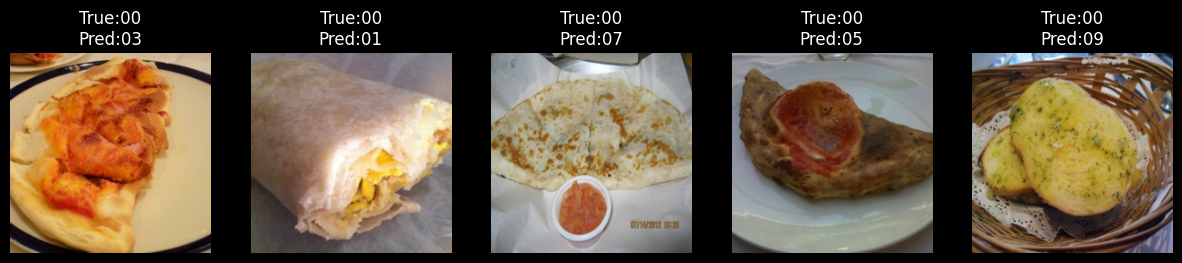

In [6]:
# 自定义模型训练
# 实例化
simple_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)

# 训练
train_model(simple_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='SimpleCNN')

# 错误样本
show_misclassified(simple_model, val_loader)

In [7]:
# 获取预处理模型
def get_model(model_name='resnet18'):
    if model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 11)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 11)
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 11)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, 11)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 11)
    else:
        raise ValueError("Unsupported model")
    return model


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6584, Val Acc = 0.8152


Epoch 2: Train Acc=0.9325, Val Acc = 0.8424


Epoch 3: Train Acc=0.9886, Val Acc = 0.8606


Epoch 4: Train Acc=0.9971, Val Acc = 0.8485


Epoch 5: Train Acc=1.0000, Val Acc = 0.8591


Epoch 6: Train Acc=1.0000, Val Acc = 0.8606


Epoch 7: Train Acc=1.0000, Val Acc = 0.8591


Epoch 8: Train Acc=0.9997, Val Acc = 0.8576


Epoch 9: Train Acc=0.9977, Val Acc = 0.8667


Epoch 10: Train Acc=0.9997, Val Acc = 0.8485


Epoch 11: Train Acc=0.9997, Val Acc = 0.8439


Epoch 12: Train Acc=0.9977, Val Acc = 0.8394


Epoch 13: Train Acc=0.9958, Val Acc = 0.8394


Epoch 14: Train Acc=0.9997, Val Acc = 0.8561


Epoch 15: Train Acc=0.9994, Val Acc = 0.8439


Epoch 16: Train Acc=0.9997, Val Acc = 0.8591


Epoch 17: Train Acc=0.9925, Val Acc = 0.8227


Epoch 18: Train Acc=0.9906, Val Acc = 0.8212


Epoch 19: Train Acc=0.9899, Val Acc = 0.8136


Epoch 20: Train Acc=0.9906, Val Acc = 0.8197


Epoch 21: Train Acc=0.9886, Val Acc = 0.8348


Epoch 22: Train Acc=0.9945, Val Acc = 0.8333


Epoch 23: Train Acc=0.9997, Val Acc = 0.8591


Epoch 24: Train Acc=0.9997, Val Acc = 0.8652


Epoch 25: Train Acc=0.9974, Val Acc = 0.8576


Epoch 26: Train Acc=0.9990, Val Acc = 0.8561


Epoch 27: Train Acc=1.0000, Val Acc = 0.8485


Epoch 28: Train Acc=1.0000, Val Acc = 0.8561


Epoch 29: Train Acc=1.0000, Val Acc = 0.8545


Epoch 30: Train Acc=1.0000, Val Acc = 0.8636


Epoch 31: Train Acc=1.0000, Val Acc = 0.8545


Epoch 32: Train Acc=1.0000, Val Acc = 0.8621


Epoch 33: Train Acc=1.0000, Val Acc = 0.8576


Epoch 34: Train Acc=1.0000, Val Acc = 0.8667


Epoch 35: Train Acc=1.0000, Val Acc = 0.8621


Epoch 36: Train Acc=0.9997, Val Acc = 0.8515


Epoch 37: Train Acc=0.9964, Val Acc = 0.8409


Epoch 38: Train Acc=0.9974, Val Acc = 0.8364


Epoch 39: Train Acc=0.9987, Val Acc = 0.8348


Epoch 40: Train Acc=0.9984, Val Acc = 0.8424


Epoch 41: Train Acc=0.9974, Val Acc = 0.8379


Epoch 42: Train Acc=0.9997, Val Acc = 0.8333


Epoch 43: Train Acc=0.9984, Val Acc = 0.8333


Epoch 44: Train Acc=0.9990, Val Acc = 0.8409


Epoch 45: Train Acc=0.9981, Val Acc = 0.8318


Epoch 46: Train Acc=0.9990, Val Acc = 0.8530


Epoch 47: Train Acc=0.9984, Val Acc = 0.8439


Epoch 48: Train Acc=0.9994, Val Acc = 0.8485


Epoch 49: Train Acc=0.9958, Val Acc = 0.8333


Epoch 50: Train Acc=0.9997, Val Acc = 0.8258


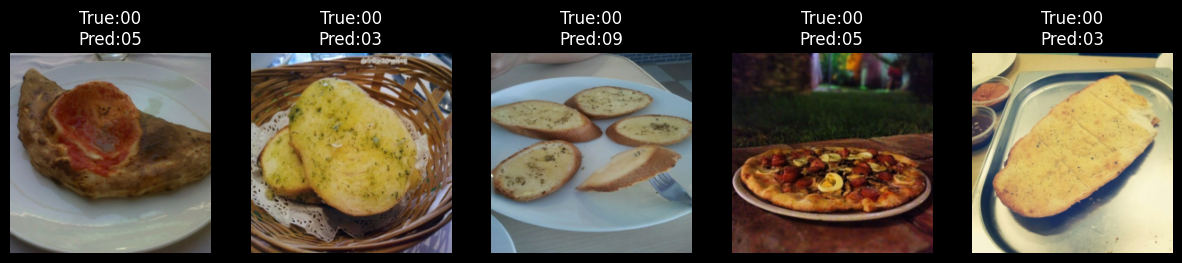

In [8]:
# ResNet 训练
# 选择模型
resnet_model = get_model('resnet18').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

# 训练
train_model(resnet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='ResNet18')

# 错误样本
show_misclassified(resnet_model, val_loader)


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.5078, Val Acc = 0.6333


Epoch 2: Train Acc=0.7338, Val Acc = 0.7106


Epoch 3: Train Acc=0.8201, Val Acc = 0.7121


Epoch 4: Train Acc=0.8844, Val Acc = 0.7152


Epoch 5: Train Acc=0.9247, Val Acc = 0.7409


Epoch 6: Train Acc=0.9646, Val Acc = 0.7348


Epoch 7: Train Acc=0.9737, Val Acc = 0.7455


Epoch 8: Train Acc=0.9786, Val Acc = 0.7455


Epoch 9: Train Acc=0.9666, Val Acc = 0.7167


Epoch 10: Train Acc=0.9766, Val Acc = 0.7106


Epoch 11: Train Acc=0.9860, Val Acc = 0.7636


Epoch 12: Train Acc=0.9929, Val Acc = 0.7485


Epoch 13: Train Acc=0.9961, Val Acc = 0.7561


Epoch 14: Train Acc=0.9877, Val Acc = 0.7439


Epoch 15: Train Acc=0.9912, Val Acc = 0.7470


Epoch 16: Train Acc=0.9828, Val Acc = 0.7606


Epoch 17: Train Acc=0.9932, Val Acc = 0.7545


Epoch 18: Train Acc=0.9974, Val Acc = 0.7652


Epoch 19: Train Acc=0.9984, Val Acc = 0.7591


Epoch 20: Train Acc=0.9955, Val Acc = 0.7439


Epoch 21: Train Acc=0.9922, Val Acc = 0.7379


Epoch 22: Train Acc=0.9916, Val Acc = 0.7379


Epoch 23: Train Acc=0.9893, Val Acc = 0.7394


Epoch 24: Train Acc=0.9942, Val Acc = 0.7606


Epoch 25: Train Acc=0.9994, Val Acc = 0.7576


Epoch 26: Train Acc=0.9981, Val Acc = 0.7455


Epoch 27: Train Acc=0.9916, Val Acc = 0.7212


Epoch 28: Train Acc=0.9971, Val Acc = 0.7530


Epoch 29: Train Acc=0.9974, Val Acc = 0.7348


Epoch 30: Train Acc=0.9948, Val Acc = 0.7197


Epoch 31: Train Acc=0.9977, Val Acc = 0.7455


Epoch 32: Train Acc=0.9932, Val Acc = 0.7197


Epoch 33: Train Acc=0.9964, Val Acc = 0.7561


Epoch 34: Train Acc=0.9964, Val Acc = 0.7455


Epoch 35: Train Acc=0.9987, Val Acc = 0.7682


Epoch 36: Train Acc=0.9994, Val Acc = 0.7576


Epoch 37: Train Acc=0.9948, Val Acc = 0.7439


Epoch 38: Train Acc=0.9955, Val Acc = 0.7455


Epoch 39: Train Acc=0.9951, Val Acc = 0.7409


Epoch 40: Train Acc=0.9977, Val Acc = 0.7591


Epoch 41: Train Acc=0.9860, Val Acc = 0.7258


Epoch 42: Train Acc=0.9890, Val Acc = 0.7258


Epoch 43: Train Acc=0.9857, Val Acc = 0.7303


Epoch 44: Train Acc=0.9903, Val Acc = 0.7273


Epoch 45: Train Acc=0.9971, Val Acc = 0.7258


Epoch 46: Train Acc=0.9942, Val Acc = 0.7333


Epoch 47: Train Acc=0.9984, Val Acc = 0.7470


Epoch 48: Train Acc=0.9948, Val Acc = 0.7348


Epoch 49: Train Acc=0.9977, Val Acc = 0.7197


Epoch 50: Train Acc=0.9994, Val Acc = 0.7545


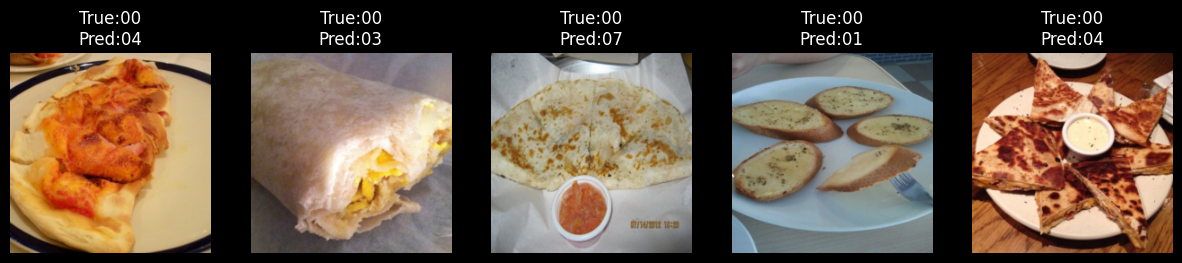

In [9]:
# AlexNet 训练
# 选择模型
alexnet_model = get_model('alexnet').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=1e-4)

# 训练
train_model(alexnet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='alexnet')

# 错误样本
show_misclassified(alexnet_model, val_loader)


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6156, Val Acc = 0.7924


Epoch 2: Train Acc=0.9068, Val Acc = 0.8606


Epoch 3: Train Acc=0.9744, Val Acc = 0.8652


Epoch 4: Train Acc=0.9903, Val Acc = 0.8773


Epoch 5: Train Acc=0.9955, Val Acc = 0.8773


Epoch 6: Train Acc=0.9977, Val Acc = 0.8758


Epoch 7: Train Acc=0.9968, Val Acc = 0.8788


Epoch 8: Train Acc=0.9971, Val Acc = 0.8803


Epoch 9: Train Acc=0.9968, Val Acc = 0.8712


Epoch 10: Train Acc=0.9987, Val Acc = 0.8833


Epoch 11: Train Acc=0.9987, Val Acc = 0.8833


Epoch 12: Train Acc=0.9984, Val Acc = 0.8758


Epoch 13: Train Acc=0.9971, Val Acc = 0.8803


Epoch 14: Train Acc=0.9984, Val Acc = 0.8894


Epoch 15: Train Acc=0.9951, Val Acc = 0.8788


Epoch 16: Train Acc=0.9997, Val Acc = 0.8788


Epoch 17: Train Acc=1.0000, Val Acc = 0.8864


Epoch 18: Train Acc=0.9981, Val Acc = 0.8682


Epoch 19: Train Acc=0.9935, Val Acc = 0.8500


Epoch 20: Train Acc=0.9945, Val Acc = 0.8545


Epoch 21: Train Acc=0.9925, Val Acc = 0.8561


Epoch 22: Train Acc=0.9922, Val Acc = 0.8591


Epoch 23: Train Acc=0.9977, Val Acc = 0.8652


Epoch 24: Train Acc=0.9981, Val Acc = 0.8682


Epoch 25: Train Acc=0.9977, Val Acc = 0.8682


Epoch 26: Train Acc=0.9987, Val Acc = 0.8682


Epoch 27: Train Acc=0.9857, Val Acc = 0.8621


Epoch 28: Train Acc=0.9916, Val Acc = 0.8500


Epoch 29: Train Acc=0.9929, Val Acc = 0.8545


Epoch 30: Train Acc=0.9990, Val Acc = 0.8697


Epoch 31: Train Acc=0.9984, Val Acc = 0.8712


Epoch 32: Train Acc=0.9997, Val Acc = 0.8742


Epoch 33: Train Acc=1.0000, Val Acc = 0.8803


Epoch 34: Train Acc=0.9997, Val Acc = 0.8758


Epoch 35: Train Acc=0.9981, Val Acc = 0.8485


Epoch 36: Train Acc=0.9864, Val Acc = 0.8424


Epoch 37: Train Acc=0.9990, Val Acc = 0.8591


Epoch 38: Train Acc=0.9932, Val Acc = 0.8545


Epoch 39: Train Acc=0.9883, Val Acc = 0.8697


Epoch 40: Train Acc=0.9977, Val Acc = 0.8621


Epoch 41: Train Acc=0.9938, Val Acc = 0.8667


Epoch 42: Train Acc=0.9997, Val Acc = 0.8773


Epoch 43: Train Acc=0.9964, Val Acc = 0.8818


Epoch 44: Train Acc=0.9955, Val Acc = 0.8773


Epoch 45: Train Acc=0.9994, Val Acc = 0.8879


Epoch 46: Train Acc=0.9990, Val Acc = 0.8803


Epoch 47: Train Acc=0.9899, Val Acc = 0.8803


Epoch 48: Train Acc=0.9990, Val Acc = 0.8803


Epoch 49: Train Acc=0.9997, Val Acc = 0.8712


Epoch 50: Train Acc=1.0000, Val Acc = 0.8879


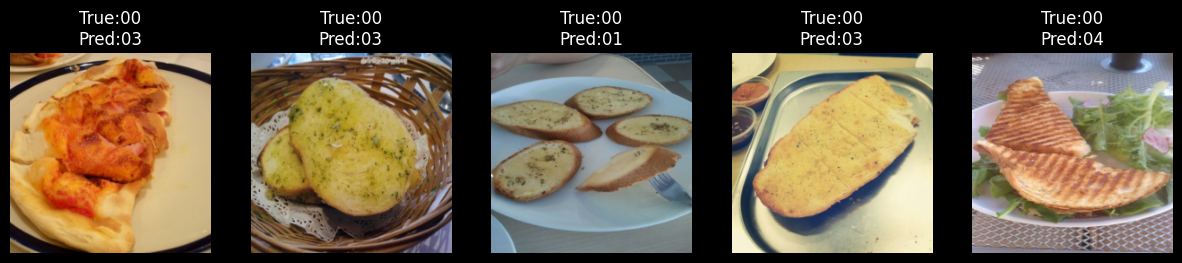

In [10]:
# Densenet 训练
# 选择模型
densenet_model = get_model('densenet121').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=1e-4)

# 训练
train_model(densenet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='densenet')

# 错误样本
show_misclassified(densenet_model, val_loader)


d:\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6133, Val Acc = 0.7909


Epoch 2: Train Acc=0.8727, Val Acc = 0.8424


Epoch 3: Train Acc=0.9451, Val Acc = 0.8561


Epoch 4: Train Acc=0.9815, Val Acc = 0.8606


Epoch 5: Train Acc=0.9951, Val Acc = 0.8758


Epoch 6: Train Acc=0.9981, Val Acc = 0.8833


Epoch 7: Train Acc=0.9997, Val Acc = 0.8758


Epoch 8: Train Acc=1.0000, Val Acc = 0.8773


Epoch 9: Train Acc=0.9994, Val Acc = 0.8803


Epoch 10: Train Acc=0.9964, Val Acc = 0.8636


Epoch 11: Train Acc=0.9994, Val Acc = 0.8697


Epoch 12: Train Acc=0.9971, Val Acc = 0.8591


Epoch 13: Train Acc=0.9997, Val Acc = 0.8667


Epoch 14: Train Acc=0.9997, Val Acc = 0.8788


Epoch 15: Train Acc=0.9997, Val Acc = 0.8803


Epoch 16: Train Acc=0.9951, Val Acc = 0.8667


Epoch 17: Train Acc=0.9890, Val Acc = 0.8485


Epoch 18: Train Acc=0.9971, Val Acc = 0.8470


Epoch 19: Train Acc=0.9958, Val Acc = 0.8485


Epoch 20: Train Acc=0.9942, Val Acc = 0.8500


Epoch 21: Train Acc=0.9994, Val Acc = 0.8576


Epoch 22: Train Acc=0.9990, Val Acc = 0.8591


Epoch 23: Train Acc=1.0000, Val Acc = 0.8667


Epoch 24: Train Acc=1.0000, Val Acc = 0.8652


Epoch 25: Train Acc=0.9968, Val Acc = 0.8606


Epoch 26: Train Acc=0.9854, Val Acc = 0.8424


Epoch 27: Train Acc=0.9994, Val Acc = 0.8591


Epoch 28: Train Acc=0.9990, Val Acc = 0.8515


Epoch 29: Train Acc=1.0000, Val Acc = 0.8576


Epoch 30: Train Acc=1.0000, Val Acc = 0.8561


Epoch 31: Train Acc=0.9987, Val Acc = 0.8576


Epoch 32: Train Acc=0.9857, Val Acc = 0.8273


Epoch 33: Train Acc=0.9912, Val Acc = 0.8288


Epoch 34: Train Acc=0.9968, Val Acc = 0.8515


Epoch 35: Train Acc=0.9981, Val Acc = 0.8667


Epoch 36: Train Acc=0.9847, Val Acc = 0.8485


Epoch 37: Train Acc=0.9867, Val Acc = 0.8394


Epoch 38: Train Acc=0.9968, Val Acc = 0.8470


Epoch 39: Train Acc=1.0000, Val Acc = 0.8515


Epoch 40: Train Acc=1.0000, Val Acc = 0.8530


Epoch 41: Train Acc=0.9997, Val Acc = 0.8545


Epoch 42: Train Acc=0.9955, Val Acc = 0.8439


Epoch 43: Train Acc=0.9981, Val Acc = 0.8530


Epoch 44: Train Acc=1.0000, Val Acc = 0.8515


Epoch 45: Train Acc=1.0000, Val Acc = 0.8667


Epoch 46: Train Acc=1.0000, Val Acc = 0.8606


Epoch 47: Train Acc=0.9990, Val Acc = 0.8545


Epoch 48: Train Acc=0.9873, Val Acc = 0.8364


Epoch 49: Train Acc=0.9955, Val Acc = 0.8515


Epoch 50: Train Acc=0.9997, Val Acc = 0.8364


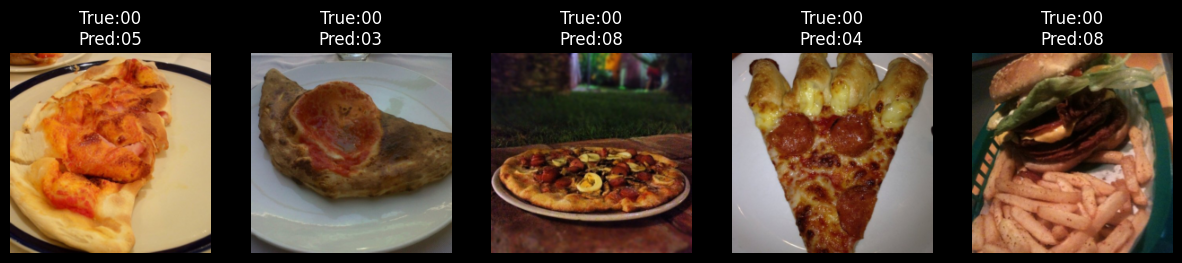

In [11]:
# MobileNet 训练
# 选择模型
mobilenet_model = get_model('mobilenet_v2').to(device)

# 损失&优化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=1e-4)

# 训练
train_model(mobilenet_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name='mobilenet')

# 错误样本
show_misclassified(mobilenet_model, val_loader)


In [12]:
# 测试集推理
class FoodTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.image_paths = sorted([
            os.path.join(root, fname)
            for fname in os.listdir(root)
            if fname.lower().endswith(('.jpg', '.png'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.image_paths[index])

In [13]:
test_dataset = FoodTestDataset(
    os.path.join(data_dir, 'testing', '00'),
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [14]:
import csv

def predict_and_save(model, test_loader, output_csv='submission.csv'):
    model.eval()
    results = []

    with torch.no_grad():
        for imgs, fname in tqdm(test_loader, desc='Predicting'):
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()
            for fname, pred in zip(fname, preds):
                results.append((fname, pred))

    with open(output_csv, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Id', 'Category'])
        writer.writerows(results)

    print(f"预测结果保存到 {output_csv}")